In [3]:
#%pylab inline
import seaborn as sns
#import urllib2
import urllib3  as urllib2
import pandas as pd
import re
import operator
from datetime import datetime, date, time
from bs4 import BeautifulSoup
import numpy as np
import itertools
import math
import time

BETA=4.166666666666667
from IPython.core.display import display, HTML
import csv
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
#!pip install trueskill

mkl-random 1.0.1 requires cython, which is not installed.
mkl-fft 1.0.4 requires cython, which is not installed.
boto3 1.8.2 has requirement botocore<1.12.0,>=1.11.2, but you'll have botocore 1.7.9 which is incompatible.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
from trueskill import Rating, quality_1vs1, rate_1vs1, quality, rate, global_env

/usr/local/anaconda3/envs/Conda3/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


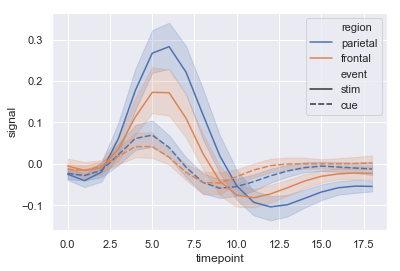

In [7]:
import seaborn as sns
sns.set(style="darkgrid")

# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")

# Plot the responses for different events and regions
sns.lineplot(x="timepoint", y="signal",
             hue="region", style="event",
             data=fmri)

In [7]:
!seaborn -V

/bin/sh: seaborn: command not found


In [8]:
## Configuration Settings
match_start_id = 1
match_end_id = 1900
player_start_id = 1
player_end_id = 190

# Scrape and Parse URL

In [9]:
## SOUP ATTRIBUTES
def make_soup(url, _id):
    quote_page = url+str(_id)  # specify the url
    page = urllib2.urlopen(quote_page)  # query the website and return the html to the variable ‘page’
    return BeautifulSoup(page, 'html.parser')

def get_header(_soup, _remove, _type):
    h = _soup.find('h1').text.strip().replace(_remove,'')
    if _type == 'event':
        event_date = datetime.datetime.strptime(h, '%A, %B %d, %Y')
        h = {'datetime': event_date.strftime('%Y%m%d'),'day': event_date.strftime('%A')}
        h = h['datetime']
    return h

def get_tag(_soup, _remove, _tag):
    t = _soup.find(_tag).text.strip().replace(_remove,'')
    return t

def get_table_data(_soup):
    name_box = _soup.find('table')
    name_rows = name_box.find_all('tr') 
    strip = [a.text.strip().replace('\r\n','') for a in name_rows]
    strip = [a.split('\n') for a in strip]
    return strip

def scrape_url(_url, _id):
    soup = make_soup(_url, _id)
    table = get_table_data(soup)
    return soup, table

# Teams

## Teams > Scrape Team General Team Info

In [10]:
def scrape_team_info(division='all'):
    url = 'http://collegebeachvb.com/colleges'
    id_ = ''
    table = get_table_data(make_soup(url, id_))

    my_labels = table[0]
    my_results = table[1:]
    df_ = pd.DataFrame.from_records(my_results,columns=my_labels) 

    if division != 'all':
        df_ = df_[df_.Division == division][['College', 'Team Name', 'Location', 'Division']]
    else:
        df_ = df_[['College', 'Team Name', 'Location', 'Division']]
    
    return df_

#df_teams = scrape_team_info()
df_teams = pd.read_csv('Data/beachvb_teams.csv').iloc[:,1:]
df_teams['College'] = df_teams['College'].apply(lambda x: x.strip())
df_teams['Team Name'] = df_teams['Team Name'].apply(lambda x: x.strip())
df_teams['Division'] = df_teams['Division'].apply(lambda x: x.strip())
df_teams

,College,Team Name,Location,Division
0,Abilene Christian,Wildcats,"Abilene, Tx",DI
1,Antelope Valley College,Marauders,"Los Angeles, Ca",Community College
2,Arizona,Wildcats,"Tucson, Az",DI
3,ASU,Sun Devils,"Tempe, Az",DI
4,Austin Peay State,Governors,"Clarksville, Tn",DI
5,Bakersfield College,Renegades,"Bakersfield, Ca",Community College
6,Benedictine,Ravens,"Mesa, Az",NAIA
7,Boise State,Broncos,"Boise, Id",DI
8,Cabrillo,Seahawks,"Aptos, Ca",Community College
9,Cal,Bears,"Berkeley,Ca",DI


# Players
## Players > Scrape Player Info

In [11]:
# This is only for 2018 rosters

def scrape_player_info(start= player_start_id, end= player_end_id):
    url = 'http://collegebeachvb.com/players/collegeplayers/'
    d = {}
    temp = None
    for i in range(start, end):
        print(i,)
        soup, table = scrape_url(url, i)
        header = soup.find('h1').text.strip().replace('College Players for ','')
        if (len(table) > 1) :
            if (len(table[1:][1]) == 4): 
                my_results = table[1:]
                my_labels = table[0]
                col_numbers = len(table[1:][0])
                my_results = table[1:]

                d[i] = pd.DataFrame.from_records(my_results, columns=['Name', 'Year', 'Height', 'Hometown/HS'])
                d[i]['Team'] = header
                d[i]['Name'] = d[i]['Name'].apply(lambda x: x.strip())
                #print d
            elif (len(table[1:][1]) == 1): 
                d[i] = pd.DataFrame.from_records(my_results, columns=['Name', 'Year', 'Height', 'Hometown/HS'])
                d[i]['Team'] = header
                d[i]['Name'] = d[i]['Name'].apply(lambda x: x.strip())
            elif (len(table[1:][1]) == 2): 
                d[i] = pd.DataFrame.from_records(my_results, columns=['Name', 'Year', 'Height', 'Hometown/HS'])
                d[i]['Team'] = header
                d[i]['Name'] = d[i]['Name'].apply(lambda x: x.strip())
            else:
                print(i, len(table[1:][1]))
                d[i] = pd.DataFrame.from_records(my_results, columns=['Name', 'Year', 'Height', 'Hometown/HS'])
                d[i]['Team'] = header
                d[i]['Name'] = d[i]['Name'].apply(lambda x: x.strip())
            
        temp = pd.concat([d[k] for k in d.keys()], axis=0)
                
    return temp

#df_players = scrape_player_info()
#df_players

df_players = pd.read_csv('Data/beachvb_players.csv').iloc[:,1:]
df_players['Name'] = df_players['Name'].apply(lambda x: x.strip())
df_players['Team'] = df_players['Team'].apply(lambda x: x.strip())
df_players

,Name,Year,Height,Hometown/HS,Team
0,Alyssa Slagerman,Fr,5'7,"Brentwood, Ca",UCLA
1,Cami Sanchez,Fr,5'10,"Fountain Valley, Ca",UCLA
2,Chanti Holroyd,So,5-9,"Mountain View, California",UCLA
3,Elise Zappia,Sr,5'8,"Huntington Beach, California",UCLA
4,Hannah Phair,Fr,5'10,"Huntington Beach, Ca",UCLA
5,Izzy Carey,Jr,5-11,"Westlake Village, California",UCLA
6,Jamie McQuarrie,Fr,6'0,"Encinitas, Ca",UCLA
7,Lexi Jasper-Baylin,Sr,5'6,"El Cajon, Ca",UCLA
8,Lily Justine,So,5-10,"Chico, California",UCLA
9,Mac May,Fr,6'3,"Dubuque, IA",UCLA


In [12]:
df_players[df_players['Name'].str.contains('Sponcil')]

,Name,Year,Height,Hometown/HS,Team
15,Sarah Sponcil,Sr,5'10,"Phoenix, Az",UCLA


In [ ]:
df_players.to_csv("beachvb_players.csv", encoding='utf-8')
df_teams.to_csv("beachvb_teams.csv", encoding='utf-8')
df_matchups.to_csv("beachvb_matchups.csv", encoding='utf-8')
df_player_rating.to_csv("beachvb_playerrating.csv", encoding='utf-8')
df_2018_d1_matchups.to_csv("beachvb_2018d1_matchups.csv", encoding='utf-8')
df_2018_matchups.to_csv("beachvb_2018_matchups.csv", encoding='utf-8')
df_2018_d1p1_matchups.to_csv("beachvb_2018d1p1_matchups.csv", encoding='utf-8')
df_2018_d1p2_matchups.to_csv("beachvb_2018d1p2_matchups.csv", encoding='utf-8')
df_2018_d1p3_matchups.to_csv("beachvb_2018d1p3_matchups.csv", encoding='utf-8')
df_2018_d1p4_matchups.to_csv("beachvb_2018d1p4_matchups.csv", encoding='utf-8')
df_2018_d1p5_matchups.to_csv("beachvb_2018d1p5_matchups.csv", encoding='utf-8')

# Matchups
## Matchups > Scrape Matchup Info

In [13]:
def scrape_matchups(start=match_start_id, end=match_end_id):
    url = 'http://collegebeachvb.com/scores/competition/'
    d = {}
    h = {}
    for i in range(start,end):
        print(i)
        try:
            table = scrape_url(url, i)[1]
            soup = scrape_url(url, i)[0]

            header = soup.find('h1').text.strip().replace('Competition on ','')
            header = datetime.strptime(str(header), '%A, %B %d, %Y').strftime('%Y%m%d')
            
            d[i] = table
            h[i] = header
        except:
            print("need to wait....")
            time.sleep(360)
            table = scrape_url(url, i)[1]
            soup = scrape_url(url, i)[0]

            header = soup.find('h1').text.strip().replace('Competition on ','')
            header = datetime.strptime(str(header), '%A, %B %d, %Y').strftime('%Y%m%d')

            d[i] = table
            h[i] = header
    return d, h


df_matchups = pd.read_csv('Data/beachvb_matchups.csv').iloc[:,1:]
for i in range(1,7):
    df_matchups.iloc[:,i] = df_matchups.iloc[:,i].apply(lambda x: x.strip())
    #df_matchups['Team'] = df_players['Team'].apply(lambda x: x.strip())
df_matchups
#s =scrape_matchups(780, 1870)

,Position,TeamAPlayer1,TeamAPlayer2,TeamBPlayer1,TeamBPlayer2,Winner,Loser,Compid,Event Date
0,1,Alexandra Spadaro,Nikki McDaniel,Kristen Brooks,Samantha Perillo,Webber,Stevenson,780,20170316
1,2,Carlee Baxter,Tessa Colden,Lauren Weaver,Katie Leftridge,Webber,Stevenson,780,20170316
2,3,Brianna Baez,Michelle Calderon,Trang Christensen,Grace Coleman,Webber,Stevenson,780,20170316
3,4,Amber Lake,Hannah Tannone,Darian Hileman,Megan Hren,Webber,Stevenson,780,20170316
4,5,Katie Schueman,Laura Embry,Deanna Bradbury,Chelsea Ireland,Webber,Stevenson,780,20170316
5,1,Lauren Weaver,Katie Leftridge,Cha Cha Fisher,Emelie Frederikson,Stevenson,Principia,781,20170318
6,2,Grace Coleman,Trang Christensen,Nikki Matters,Devon Marunde,Stevenson,Principia,781,20170318
7,3,Sara Bollinger,Samantha Perillo,Noelle Shoemake,Sophia Hathaway,Principia,Stevenson,781,20170318
8,4,Darian Hileman,Megan Hren,Makena Patterson,Victoria Vandiver,Stevenson,Principia,781,20170318
9,5,Deanna Bradbury,Chelsea Ireland,Amanda Roberts,Mesa Goebel,Stevenson,Principia,781,20170318


# Matchups
## Matchups > Select Matchups

In [14]:
def select_matchups(startdate, enddate, df=df_matchups, division='DI'):
    temp = df[df['Event Date'].astype(int) >  startdate]
    temp = temp[temp['Event Date'].astype(int) < enddate]
    df_team_players = df_players.merge(df_teams, how='inner', left_on='Team', right_on='College')
    temp = temp.merge(df_team_players, how='left', left_on='TeamAPlayer1', right_on='Name')
    temp['TeamAPlayer1'] = temp['TeamAPlayer1'].apply(lambda x: x.strip())
    temp['TeamAPlayer2'] = temp['TeamAPlayer2'].apply(lambda x: x.strip())
    temp['TeamBPlayer1'] = temp['TeamBPlayer1'].apply(lambda x: x.strip())
    temp['TeamBPlayer2'] = temp['TeamBPlayer2'].apply(lambda x: x.strip())
    temp = temp[temp['Division'] == division].iloc[:,[0,1,2,3,4,5,6,7,8]].drop_duplicates()
    temp = temp.sort_values('Event Date', ascending=True)    
    return  temp

## Matchups > Prepare Matchup Data

In [15]:
def prepare_matchup_data(m_dict):
    s_new = s[0]
    d_new = s[1]
    m = {}

    temp = None
    for a in s_new:
        print(a,)
        for b in s_new[a]:
            if len(b) == 5:
                team1 =  b[1]
                team2 =  b[2]
                #print team1, team2, "\n"
            elif len(b) == 7:
                if team1 == (b[5].replace('(', '').replace(')', '')):
                    winner = team1
                    loser = team2
                else:
                    winner = team2
                    loser = team1

                m[a] = [b[0], b[1], b[2], b[3], b[4], winner, loser,a,  d_new[a]]
                #print a
                #print m
                df_ = pd.DataFrame.from_dict(m, orient='index')
                df_.columns=['Position','TeamAPlayer1', 'TeamAPlayer2', 'TeamBPlayer1', 'TeamBPlayer2',\
                                                                   'Winner', 'Loser', 'Compid', 'Event Date' ]

                temp = pd.concat([temp,df_], axis=0)
    return temp



#df_matchups = prepare_matchup_data(s)
#df_matchups.sort_values('Event Date', ascending=True)
#df_2018_matchups = select_matchups( 20180000, 20180900).sort_values('Event Date', ascending=True)
#df_2018_matchups.sort_values('Event Date', ascending=True).Compid.unique()

In [ ]:
keys = s[0].keys()
with open('matches_dict.csv', 'wb') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(s)

In [ ]:
df_matchups = df_matchups.drop_duplicates()
df_matchups

# Ratings
## Ratings > Set Defaults
### Ratings > Set Defaults > Player Ratings

In [16]:
def set_default_player_rating(df):
    df_temp = df.copy()
    df_temp['mu'] = Rating().mu
    df_temp['sigma'] = Rating().sigma
    
    df_temp = df_temp.reset_index()
    df_temp = df_temp.iloc[:, 1:]
    return df_temp

#df_player_rating = set_default_player_rating(df_players)
#df_player_rating[df_player_rating['Name'] == 'Mandi Orellana']
#df_player_rating

### Ratings > Lookup > Player Ratings

In [17]:
def lookup_player_rating(name, teams, df): 
    name = name.strip()
    teams = [a.strip() for a in teams]
    player_info =  df[(df['Name'] == name) & (df['Team'].isin(teams))].max()
    #player_info['pid'] = player_info.index
    return player_info

#lookup_player_rating('Mandi Orellana',  ['South Carolina', 'LSU'], df_player_rating)

#df_player_rating[df_player_rating['Name'] == 'Mandi Orellana']['mu'].item()

## Ratings > Update
### Ratings > Update > Update Player Ratings

In [18]:
def update_player_ratings(matches, player_rating, players):
    hist = {}
    incr = 0
    for idx, rows in matches.iterrows():
        p1_lookup =  lookup_player_rating(rows['TeamAPlayer1'],[rows['Winner'], rows['Loser']], player_rating )
        r1 = Rating(mu=p1_lookup.mu, sigma=p1_lookup.sigma)
        
        p2_lookup =  lookup_player_rating(rows['TeamAPlayer2'],[rows['Winner'], rows['Loser']], player_rating )
        r2 = Rating(mu=p2_lookup.mu, sigma=p2_lookup.sigma)
        
        p3_lookup =  lookup_player_rating(rows['TeamBPlayer1'],[rows['Winner'], rows['Loser']], player_rating )
        r3 = Rating(mu=p3_lookup.mu, sigma=p3_lookup.sigma)

        p4_lookup =  lookup_player_rating(rows['TeamBPlayer2'],[rows['Winner'], rows['Loser']], player_rating )
        r4 = Rating(mu=p4_lookup.mu, sigma=p4_lookup.sigma)
                
        
        t1 = [r1,r2]
        t2 = [r3,r4]

        if p1_lookup['Team'] == rows['Winner'].strip():
            my_ranks = [0,1]
        else:
            my_ranks = [1,0]
        
        (r1_new, r2_new), (r3_new, r4_new) = rate([t1, t2], ranks=my_ranks)

        #print rows.iloc[0],  "winner: ", rows.iloc[5],  "loser: ", rows.iloc[6]
        
        incr = incr+1
        my_index1 = player_rating[player_rating['Name'] == rows.iloc[1]].index
        #print my_index1, 
        player_rating.loc[my_index1, 'mu'] = r1_new.mu
        player_rating.loc[my_index1, 'sigma'] = r1_new.sigma
        #print rows.iloc[1] , "(before:", r1.mu, ", after:", r1_new.mu, ")"
        hist[incr] = [rows.iloc[0], rows.iloc[1], rows.iloc[5],  rows.iloc[6], rows.iloc[7],rows.iloc[8],r1.mu, r1_new.mu]
        
        incr = incr+1
        my_index2 = player_rating[player_rating['Name'] == rows.iloc[2]].index
        #print my_index2,
        player_rating.loc[my_index2, 'mu'] = r2_new.mu
        player_rating.loc[my_index2, 'sigma'] = r2_new.sigma
        #print rows.iloc[2] , "(before:", r2.mu, ", after:", r2_new.mu, ")" 
        hist[incr] = [rows.iloc[0], rows.iloc[2], rows.iloc[5],  rows.iloc[6],rows.iloc[7], rows.iloc[8], r2.mu, r2_new.mu]
        
        incr = incr+1
        my_index3 = player_rating[player_rating['Name'] == rows.iloc[3]].index
        #print my_index3,
        player_rating.loc[my_index3, 'mu'] = r3_new.mu
        player_rating.loc[my_index3, 'sigma'] = r3_new.sigma
        #print rows.iloc[3] , "(before:", r3.mu, ", after:", r3_new.mu, ")" 
        hist[incr] = [rows.iloc[0], rows.iloc[3], rows.iloc[5],  rows.iloc[6], rows.iloc[7], rows.iloc[8],r3.mu, r3_new.mu]

        incr = incr+1
        my_index4 = player_rating[player_rating['Name'] == rows.iloc[4]].index
        #print my_index4,
        player_rating.loc[my_index4, 'mu'] = r4_new.mu    
        player_rating.loc[my_index4, 'sigma'] = r4_new.sigma    
        #print rows.iloc[4] , "(before:", r4.mu, ", after:", r4_new.mu, ")" 
        hist[incr] = [rows.iloc[0], rows.iloc[4], rows.iloc[5],  rows.iloc[6], rows.iloc[7],rows.iloc[8],r4.mu, r4_new.mu]

         
        #print   "\n"
    return hist

df_player_rating = set_default_player_rating(df_players)
df_2018_matchups = select_matchups( 20180000, 20180900).sort_values(['Event Date', 'Compid', 'Position'], ascending=True).drop_duplicates()
#df_2018_matchups

rating_history = update_player_ratings(df_2018_matchups, df_player_rating, df_players) 
rating_history

{1: [1,
  'Carly Perales',
  'Stetson',
  'Eckerd',
  799,
  20180223,
  25.0,
  28.108322630298364],
 2: [1,
  'Sunniva Helland-Hansen',
  'Stetson',
  'Eckerd',
  799,
  20180223,
  25.0,
  28.108322630298364],
 3: [1,
  'Mackenzie Redner',
  'Stetson',
  'Eckerd',
  799,
  20180223,
  25.0,
  21.891677369701625],
 4: [1,
  'Savanna Cary',
  'Stetson',
  'Eckerd',
  799,
  20180223,
  25.0,
  21.891677369701625],
 5: [2,
  'Darby Dunn',
  'Stetson',
  'Eckerd',
  799,
  20180223,
  25.0,
  28.108322630298364],
 6: [2,
  'Sammee Thomas',
  'Stetson',
  'Eckerd',
  799,
  20180223,
  25.0,
  28.108322630298364],
 7: [2,
  'Paula Hoffman',
  'Stetson',
  'Eckerd',
  799,
  20180223,
  25.0,
  21.891677369701625],
 8: [2,
  'Kaitlyn Sibson',
  'Stetson',
  'Eckerd',
  799,
  20180223,
  25.0,
  21.891677369701625],
 9: [3,
  'Rebecca Ingram',
  'Stetson',
  'Eckerd',
  799,
  20180223,
  25.0,
  28.108322630298364],
 10: [3,
  'Quinci Birker',
  'Stetson',
  'Eckerd',
  799,
  20180223,


In [140]:
df_rating_history = pd.DataFrame.from_dict(rating_history, orient='index')
df_rating_history.columns=['Position', 'Name', 'Winning Team', 'Losing Team', 'Compid', 'Event Date', 'Rating Before Match', 'Rating After Match']

In [166]:
df_rating_history['Event Date'] = df_rating_history['Event Date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
df_rating_history

,Position,Name,Winning Team,Losing Team,Compid,Event Date,Rating Before Match,Rating After Match
1,1,Carly Perales,Stetson,Eckerd,799,2018-02-23,25.000000,28.108323
2,1,Sunniva Helland-Hansen,Stetson,Eckerd,799,2018-02-23,25.000000,28.108323
3,1,Mackenzie Redner,Stetson,Eckerd,799,2018-02-23,25.000000,21.891677
4,1,Savanna Cary,Stetson,Eckerd,799,2018-02-23,25.000000,21.891677
5,2,Darby Dunn,Stetson,Eckerd,799,2018-02-23,25.000000,28.108323
6,2,Sammee Thomas,Stetson,Eckerd,799,2018-02-23,25.000000,28.108323
7,2,Paula Hoffman,Stetson,Eckerd,799,2018-02-23,25.000000,21.891677
8,2,Kaitlyn Sibson,Stetson,Eckerd,799,2018-02-23,25.000000,21.891677
9,3,Rebecca Ingram,Stetson,Eckerd,799,2018-02-23,25.000000,28.108323
10,3,Quinci Birker,Stetson,Eckerd,799,2018-02-23,25.000000,28.108323


,Name,Event Date,Rating After Match,Position
425,Sarah Sponcil,2018-02-24,28.108323,2
585,Haley Hallgren,2018-02-24,27.584551,2
645,Haley Hallgren,2018-02-24,29.772447,2
668,Sarah Sponcil,2018-02-24,25.068638,2
886,Haley Hallgren,2018-02-25,30.846758,2
946,Sarah Sponcil,2018-02-25,26.562563,2
965,Haley Hallgren,2018-02-25,28.840806,2
1085,Sarah Sponcil,2018-02-25,24.948463,2
1145,Sarah Sponcil,2018-02-28,27.694064,2
1166,Sarah Sponcil,2018-02-28,29.067678,2


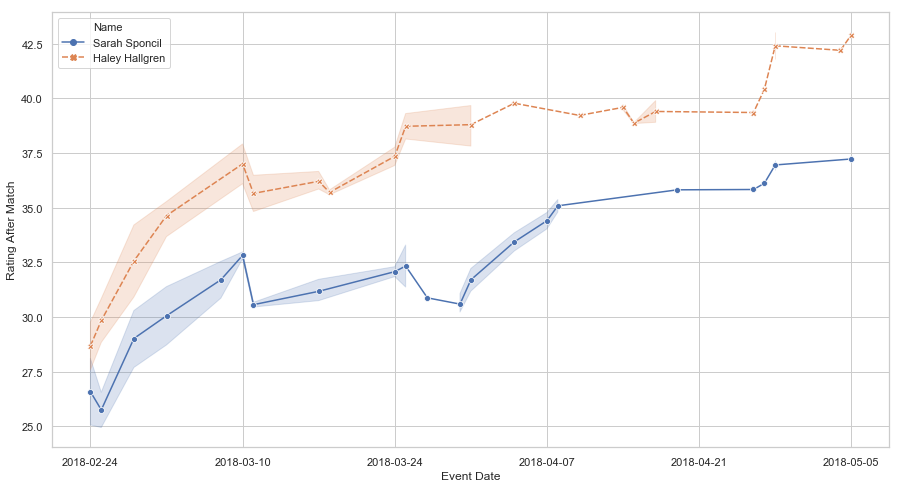

In [184]:
#df_plot = df_rating_history[df_rating_history.Name.isin(['Haley Hallgren', 'Sarah Sponcil', 'Tina Graudina','Victoria Paranagua', 'Megan McNamara', 'Abril Bustamante'])]

def show_individual_rating(player):
    df_plot = df_rating_history[df_rating_history.Name.isin(player)]
    df_plot = df_plot[['Name', 'Event Date', 'Rating After Match', 'Position' ]]
    a4_dims = (15, 8)
    fig, ax = pyplot.subplots(figsize=a4_dims)
    g = sns.lineplot(x="Event Date", y="Rating After Match", style='Name',  hue='Name', markers=True, data=df_plot, ax=ax)
    return df_plot
df_plot = show_individual_rating(['Sarah Sponcil', 'Haley Hallgren'])
df_plot

,Name,Event Date,Rating After Match,Position
525,Ka'iwi Schucht,2018-02-24,27.395291,2
666,Ka'iwi Schucht,2018-02-24,30.468229,2
1087,Ka'iwi Schucht,2018-02-25,32.262922,2
1105,Ka'iwi Schucht,2018-02-25,32.571986,2
2836,Ka'iwi Schucht,2018-03-08,28.744623,2
2854,Ka'iwi Schucht,2018-03-08,26.873979,2
3318,Ka'iwi Schucht,2018-03-10,27.618724,2
3460,Ka'iwi Schucht,2018-03-10,29.760477,2
3937,Ka'iwi Schucht,2018-03-11,30.259994,2
4014,Ka'iwi Schucht,2018-03-11,31.724015,1


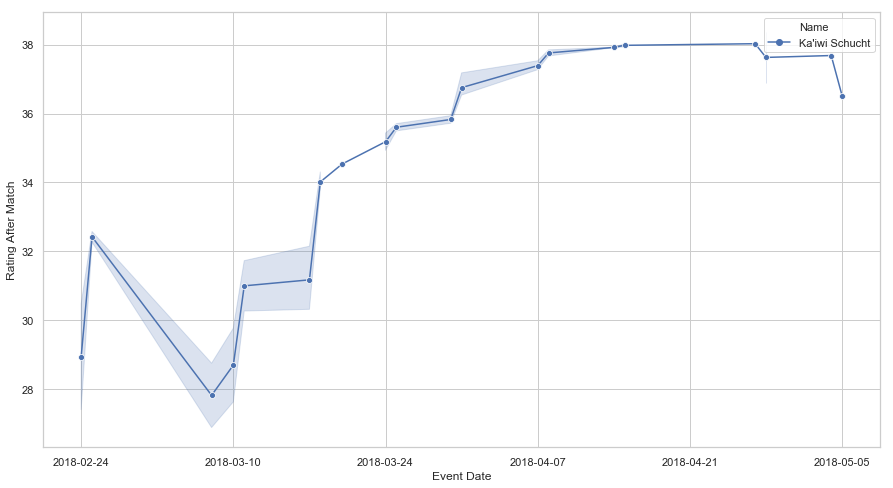

In [190]:
df_plot = show_individual_rating(["Ka'iwi Schucht"])
df_plot

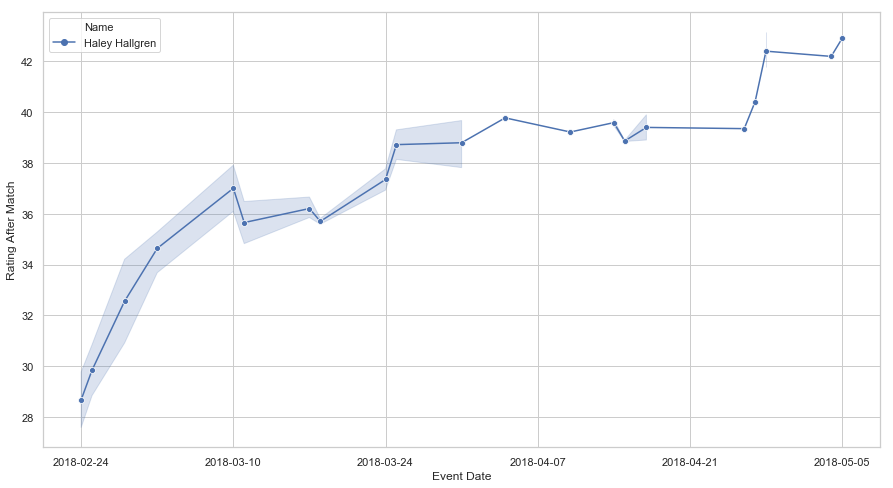

In [178]:
show_individual_rating('Haley Hallgren')

In [ ]:
def show_individual_rating(player):
    df_plot = df_rating_history[df_rating_history.Name.isin([player])]
    df_plot = df_plot[['Name', 'Event Date', 'Rating After Match', 'Position' ]]
    a4_dims = (15, 8)
    fig, ax = pyplot.subplots(figsize=a4_dims)
    g = sns.lineplot(x="Event Date", y="Rating After Match", style='Name',  hue='Name', markers=True, data=df_plot, ax=ax)
    return
show_individual_rating('Sarah Sponcil')

In [127]:
import seaborn as sns
from matplotlib import pyplot
sns.set(style="whitegrid")

def showRatingByTeam(school):
    df_plot = df_rating_history[df_rating_history.Name.isin(list(df_players[df_players['Team'] == school]['Name']))]
    df_plot = df_plot[['Name', 'Event Date', 'Rating After Match', 'Position' ]]
    a4_dims = (20.7, 8.27)
    fig, ax = pyplot.subplots(figsize=a4_dims)
    sns.lineplot(x="Event Date", y="Rating After Match",  hue='Name', markers=True, data=df_plot, ax=ax)
    return

def showTotalRatingByTeam(school):
    df_plot = df_rating_history[df_rating_history.Name.isin(list(df_players[df_players['Team'] == school]['Name']))]
    df_plot = df_plot[['Name', 'Event Date', 'Rating After Match', 'Position' ]]
    a4_dims = (11.7, 8.27)
    fig, ax = pyplot.subplots(figsize=a4_dims)
    sns.lineplot(x="Event Date", y="Rating After Match",  hue='Name', markers=True, data=df_plot, ax=ax)
    return

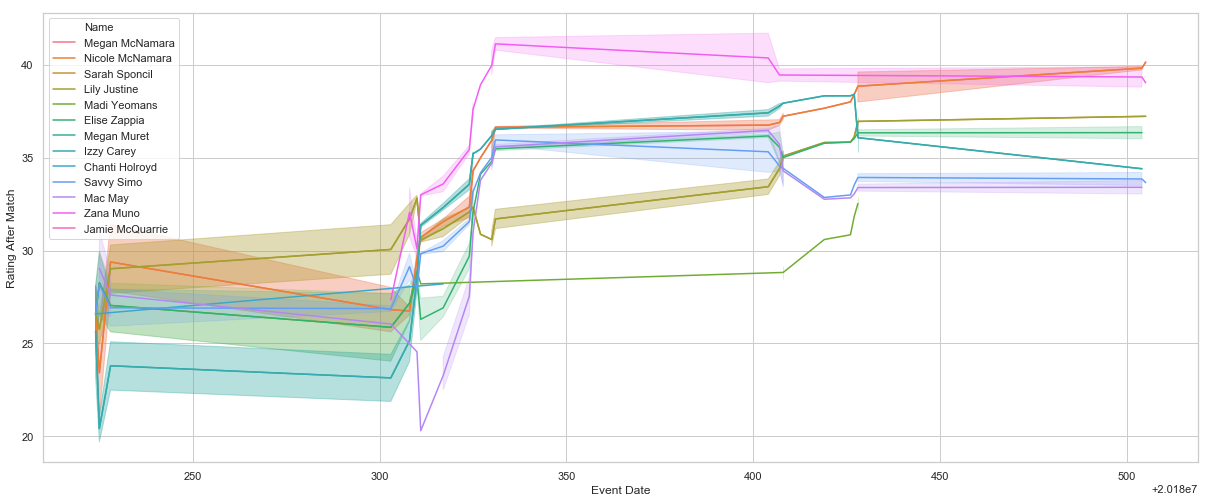

In [128]:
showRatingByTeam('UCLA')

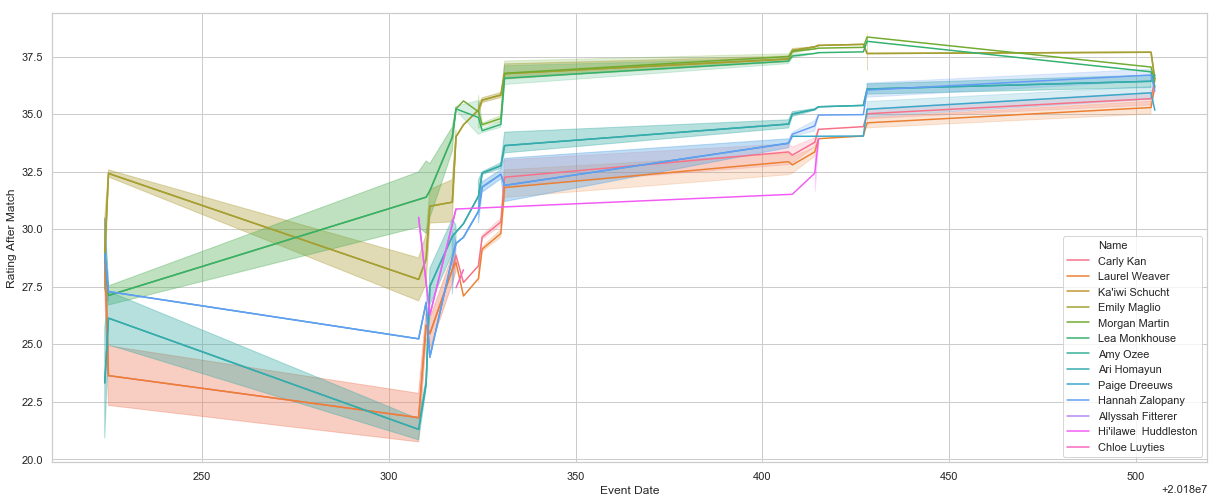

In [129]:
showRatingByTeam('Hawaii')

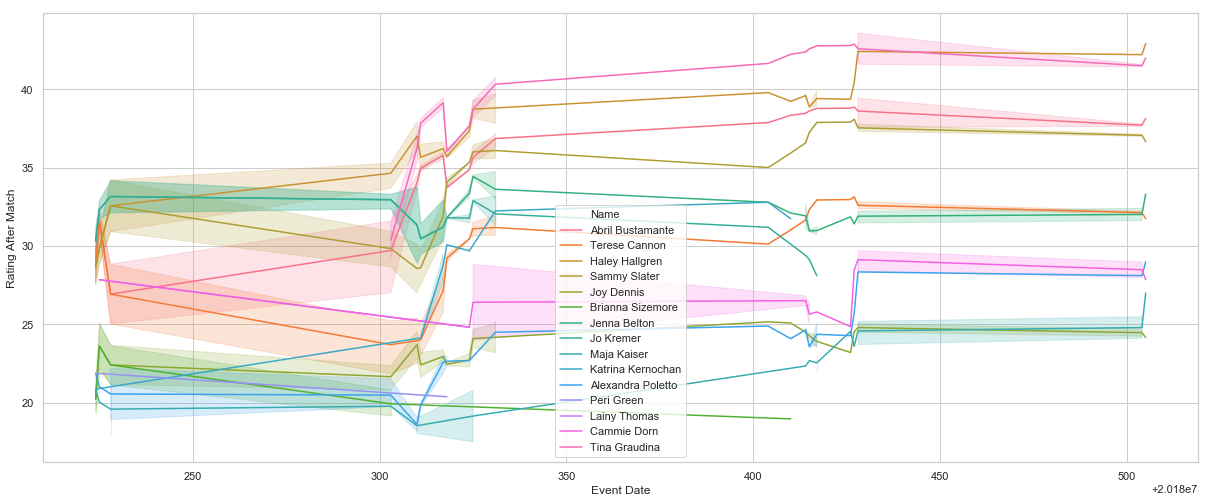

In [130]:
showRatingByTeam('USC')

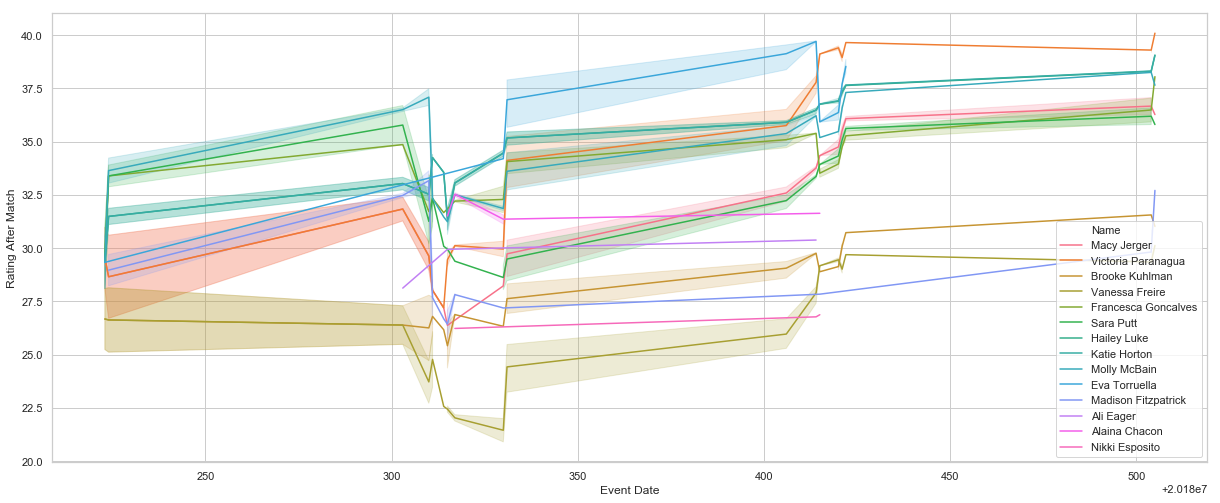

In [131]:
showRatingByTeam('Florida State')

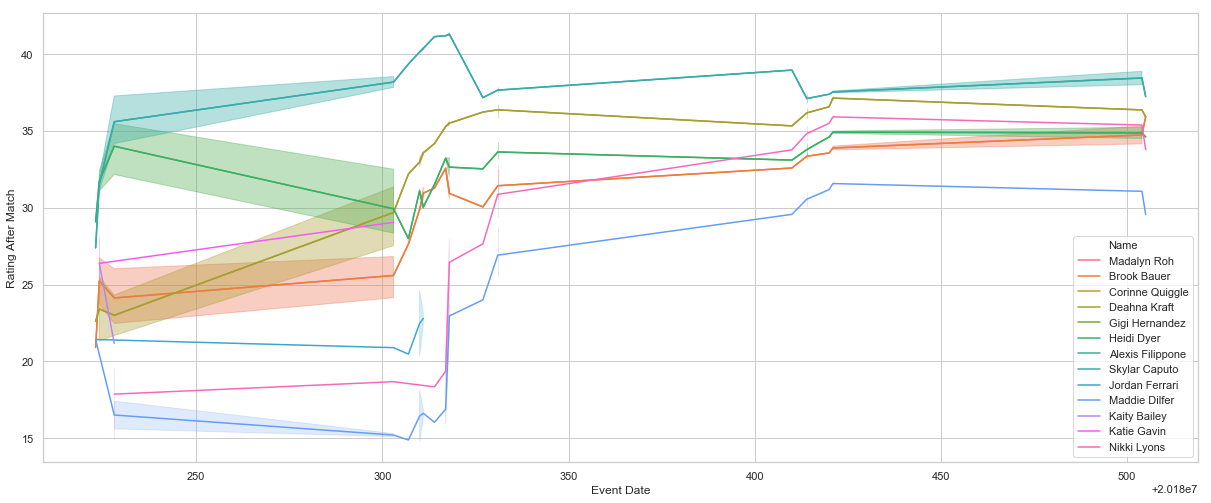

In [132]:
showRatingByTeam('Pepperdine')

In [ ]:
https://www.microsoft.com/en-us/research/project/trueskill-ranking-system/?from=http%3A%2F%2Fresearch.microsoft.com%2Fen-us%2Fprojects%2Ftrueskill%2F

# D1 Matchups

In [88]:
df_player_rating = set_default_player_rating(df_players)
df_2018_matchups = df_matchups[df_matchups['Event Date'].astype(int) > 20180000].reset_index()
df_2018_matchups = df_2018_matchups.iloc[:,1:]
d1_colleges = list(df_teams[df_teams['Division'] == 'DI'].College.unique())

df_2018_d1_matchups = df_2018_matchups[df_2018_matchups['Winner'].isin(d1_colleges)].reset_index()
df_2018_d1_matchups = df_2018_d1_matchups.iloc[:,1:]

## D1 Matchups > All Players

In [89]:
df_player_rating = set_default_player_rating(df_players)
update_player_ratings(df_2018_d1_matchups, df_player_rating, df_players)
df_player_rating.sort_values('mu', ascending=False)
df_player_rating.sort_values('mu', ascending=False).head(22)

,Name,Year,Height,Hometown/HS,Team,mu,sigma
43,Haley Hallgren,Fr,6'1,"Southlake, Tx",USC,43.188500,2.237399
53,Tina Graudina,Fr,6'0,"Jurmala, Latvia",USC,42.035975,2.916638
38,Victoria Paranagua,Sr,5'11,"Austin, Tx",Florida State,40.330936,2.481874
11,Megan McNamara,Jr,5-9,"Vancouver, BC, Canada",UCLA,40.194153,2.437909
13,Nicole McNamara,Jr,5-9,"Vancouver, BC, Canada",UCLA,40.194153,2.437909
29,Katie Horton,R-Sr,6'1,"Westland, Mich",Florida State,39.277490,3.238435
28,Hailey Luke,R-Sr,6'0,"Altamonte Springs, Fl",Florida State,39.259345,3.243604
17,Zana Muno,Jr,5'10,"Hermosa Beach, Ca",UCLA,39.120794,3.151639
448,Taylor Nelson,Sr,6'0,"Granite Bay, Ca",Cal Poly SLO,38.954251,3.416945
26,Eva Torruella,R-So,6'0,"San Juan, Puerto Rico",Florida State,38.842157,3.851715


## D1 Matchups > Position 1

In [185]:
df_player_rating_p1 = set_default_player_rating(df_players)
df_2018_d1p1_matchups = df_2018_d1_matchups[df_2018_d1_matchups['Position'].astype(int) == 1]
update_player_ratings(df_2018_d1p1_matchups, df_player_rating_p1, df_players)
df_player_rating_p1.sort_values('mu', ascending=False).head(22)

,Name,Year,Height,Hometown/HS,Team,mu,sigma
53,Tina Graudina,Fr,6'0,"Jurmala, Latvia",USC,41.377344,3.127990
13,Nicole McNamara,Jr,5-9,"Vancouver, BC, Canada",UCLA,39.907845,2.530300
11,Megan McNamara,Jr,5-9,"Vancouver, BC, Canada",UCLA,39.907845,2.530300
39,Abril Bustamante,Jr,6'0,"Redondo Beach, Ca",USC,37.625172,2.892088
38,Victoria Paranagua,Sr,5'11,"Austin, Tx",Florida State,37.599257,2.841890
62,Emily Maglio,Jr,6'3,"Coquitlam, B.C., Can",Hawaii,36.517063,4.046113
66,Ka'iwi Schucht,Sr,5'9,"Escondido, Ca",Hawaii,36.517063,4.046113
123,Nele Barber,Sr,6'0,"Berlin, Germany",Long Beach State,35.646697,3.120837
173,Claire Coppola,So,6'1,"Scottsdale, Az",LSU,35.450362,2.636258
181,Kristen Nuss,So,5'6,"New Orleans, La",LSU,35.450362,2.636258


## D1 Matchups > Position 2

In [186]:
df_player_rating_p2 = set_default_player_rating(df_players)
df_2018_d1p2_matchups = df_2018_d1_matchups[df_2018_d1_matchups['Position'].astype(int) == 2]
update_player_ratings(df_2018_d1p2_matchups, df_player_rating_p2, df_players)
df_player_rating_p2.sort_values('mu', ascending=False).head(22)

,Name,Year,Height,Hometown/HS,Team,mu,sigma
29,Katie Horton,R-Sr,6'1,"Westland, Mich",Florida State,42.522348,4.390892
28,Hailey Luke,R-Sr,6'0,"Altamonte Springs, Fl",Florida State,42.492299,4.403364
337,Brook Bauer,Fr,6'1,"Fort Lauderdale, Fl",Pepperdine,38.940498,4.031088
345,Madalyn Roh,Jr,5'11,"Scottsdale, Az",Pepperdine,38.940498,4.031088
338,Corinne Quiggle,Sr,5'10,"Ponte Vedra Beach, Fl",Pepperdine,38.614189,4.702937
339,Deahna Kraft,So,6'0,"Seattle, Wa",Pepperdine,38.614189,4.702937
213,Shannon Williams,Jr,5'10,"Ashburn, Va",South Carolina,38.193875,5.464422
193,Ali Denney,So,5'6,"Jupiter,Fl",South Carolina,38.193875,5.464422
8,Lily Justine,So,5-10,"Chico, California",UCLA,37.762547,2.710925
15,Sarah Sponcil,Sr,5'10,"Phoenix, Az",UCLA,37.762547,2.710925


## D1 Matchups > Position 3

In [187]:
df_player_rating_p3 = set_default_player_rating(df_players)
df_2018_d1p3_matchups = df_2018_d1_matchups[df_2018_d1_matchups['Position'].astype(int) == 3]
update_player_ratings(df_2018_d1p3_matchups, df_player_rating_p3, df_players)
df_player_rating_p3.sort_values('mu', ascending=False).head(22)

,Name,Year,Height,Hometown/HS,Team,mu,sigma
51,Sammy Slater,Fr,5'10,"Ventura, Ca",USC,43.452634,5.205718
60,Carly Kan,Sr,5'9,"Honolulu, Hi",Hawaii,42.056148,3.774233
67,Laurel Weaver,Sr,5'11,"Winnetka, Ca",Hawaii,40.679287,3.839074
36,Sara Putt,Jr,5'11,"Jupiter, Fl",Florida State,40.203033,3.765526
31,Macy Jerger,Jr,6'1,"Fort Myers, Fl",Florida State,39.876683,4.192145
43,Haley Hallgren,Fr,6'1,"Southlake, Tx",USC,39.180920,3.379221
16,Savvy Simo,So,5'10,"Rancho Santa Fe, Ca",UCLA,37.996745,3.107660
52,Terese Cannon,Sr,6'3,"Pittsford, N.Y.",USC,37.728811,5.666328
17,Zana Muno,Jr,5'10,"Hermosa Beach, Ca",UCLA,37.432461,3.655218
432,Adlee Van Winden,Jr,6'1,"Napa, Ca",Cal Poly SLO,35.944683,3.985935


## D1 Matchups > Position 4

In [188]:
df_player_rating_p4 = set_default_player_rating(df_players)
df_2018_d1p4_matchups = df_2018_d1_matchups[df_2018_d1_matchups['Position'].astype(int) == 4]
update_player_ratings(df_2018_d1p4_matchups, df_player_rating_p4, df_players)
df_player_rating_p4.sort_values('mu', ascending=False).head(22)

,Name,Year,Height,Hometown/HS,Team,mu,sigma
3,Elise Zappia,Sr,5'8,"Huntington Beach, California",UCLA,40.250417,3.356928
381,Emma Doud,So,5'9,"Alameda, Ca",LMU,38.631215,5.891777
55,Amy Ozee,So,6'1,"Haiku, Hi",Hawaii,38.175607,2.788368
57,Ari Homayun,Jr,5'8,"Woodland Hills, Ca",Hawaii,38.175607,2.788368
220,Jonny Baham,Fr,5'6,"Carlsbad, Ca",Arizona,37.810431,4.146799
24,Brooke Kuhlman,Jr,5'10,"Naples, Fl",Florida State,37.093374,3.815494
335,Alexis Filippone,Fr,6'2,"Del Mar, Ca",Pepperdine,36.854013,3.527747
349,Skylar Caputo,Jr,5'10,"Manhattan Beach, Ca",Pepperdine,36.854013,3.527747
34,Molly McBain,So,5'9,"Toronto, Canada",Florida State,36.723717,3.811697
29,Katie Horton,R-Sr,6'1,"Westland, Mich",Florida State,35.035033,5.263523


## D1 Matchups > Position 5

In [189]:
df_player_rating_p5 = set_default_player_rating(df_players)
df_2018_d1p5_matchups = df_2018_d1_matchups[df_2018_d1_matchups['Position'].astype(int) == 5]
update_player_ratings(df_2018_d1p5_matchups, df_player_rating_p5, df_players)
df_player_rating_p5.sort_values('mu', ascending=False).head(22)

KeyboardInterrupt: 

## Players > Rating

In [ ]:
print df_matchups[df_matchups['TeamBPlayer1'] == 'Tina Graudina']
print df_matchups[df_matchups['TeamAPlayer1'] == 'Tina Graudina']

# Probability and Statistics

In [ ]:
def win_probability(team1, team2):
    delta_mu = sum(r.mu for r in team1) - sum(r.mu for r in team2)
    sum_sigma = sum(r.sigma ** 2 for r in itertools.chain(team1, team2))
    size = len(team1) + len(team2)
    denom = math.sqrt(size * (BETA * BETA) + sum_sigma)
    ts = global_env()
    return ts.cdf(delta_mu / denom)

In [ ]:
def actual_match(compid, df):
    return df[df['Compid'].astype(int) == compid].groupby('Winner')['Position'].count()

actual_match(1863, df_matchups)

In [ ]:
def predict_match(compid, df):
    match = df[df['Compid'].astype(int) == compid].copy().reset_index().iloc[:,1:]
    for idx, rows in match.iterrows():
        r = {}
        p_lookup = {}
        t = {}
        for i in range(1,5):
            p_lookup[i] = lookup_player_rating(rows.iloc[i],[rows.iloc[5], rows.iloc[6]], df_player_rating )
            r[i] = Rating(mu=p_lookup[i].mu, sigma=p_lookup[i].sigma)
            #match[i] = r[i]
    
        t[1] = [r[1], r[2]]
        t[2] = [r[3], r[4]]
        
        win_prob = win_probability(t[1], t[2])
    
        
        match.loc[idx, 'Probability'] = win_prob 
        #print win_prob
        if (win_prob >.60):
            match.loc[idx, 'Predicted Winner'] = p_lookup[1]['Team'] 
            match.loc[idx, 'Distance From Draw'] = (win_prob - .60)
            match.loc[idx, 'T1 Win'] = 1
        elif (win_prob <.40):
            match.loc[idx, 'Predicted Winner'] = p_lookup[3]['Team'] 
            match.loc[idx, 'Distance From Draw'] = (.40-win_prob )
            match.loc[idx, 'T1 Win'] = 0
        else:
            match.loc[idx, 'Predicted Winner'] = 'Draw'
            match.loc[idx, 'Distance From Draw'] = 0
            match.loc[idx, 'T1 Win'] = .5
        
    
    return match

_df = {}
temp = None
for a in range(780, 1870):
    print a,
    _df = predict_match(a, df_matchups)
    _df = pd.concat([_df, temp], axis=0)
    temp = _df


total_no_draw = len(_df[_df['Winner'] != 'Draw'])
accurate = len(_df[_df['Winner'] == _df['Predicted Winner']])
print accurate, total_no_draw, accurate*100/total_no_draw

_df

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
y_true = list(_df['T1 Win'])
y_pred = list(_df['Probability'])
accuracy_score(y_true, y_pred)

#accuracy_score(y_true, y_pred, normalize=False)


In [ ]:
_df = _df.reset_index()
_df = _df.iloc[:,1:]
_df['Actual'] = 0
idx = _df.index[_df['Winner'] == _df['Predicted Winner']]
#_df.index = idx, 'Actual'] = 1
#df.Actual.where[_df['Winner'] == _df['Predicted Winner']])

_df['Actual'] = np.where(_df['Winner'] == _df['Predicted Winner'], 1, 0)
_df

In [ ]:
new = _df[['Predicted Winner', 'Winner', 'Loser', 'Probability', 'Distance From Draw']].sort_values('Distance From Draw', ascending=False)
for idx, rows in new.iterrows():
    print rows[0],rows[1],  rows[4]

## 2019 Potential (Look for Pre-season Rankings)
Takes a look at team without last year's seniors

In [ ]:
df_2019_Potential = df_player_rating[~df_player_rating['Year'].isin(['Sr','R-Sr', 'GS'])].sort_values('mu', ascending=False)
df_2019_Potential = df_2019_Potential.groupby('Team')['mu'].nlargest(8).sum(level=0).sort_values(ascending=False).to_frame()
df_2019_Potential.columns = ['Total K Score']
df_2019_Potential
#filter out D1s

In [ ]:
#Strength of schedule?

## 2018 Post Season Team Strength Ranking By Top 10 Cumulative Player Score

In [ ]:
df_2018_final = df_player_rating.sort_values('mu', ascending=False)
df_2018_final = df_2018_final.groupby('Team')['mu'].nlargest(10).sum(level=0).sort_values(ascending=False).to_frame()
df_2018_final.columns = ['Total K Score']
df_2018_final

In [ ]:
def predictMatch(_compid, _df):
    _match = df_all_matchups[df_all_matchups['CompID'] == _compid].iloc[:,0:5]
    wins = {}

    for i in range(0,len(_match)):
        r = [Rating(lookupPlayerRating(_match.iloc[i,j], predict_ranking))  for j in range(1,5)]

        t1 = [r[0], r[1]]
        t2 = [r[2], r[3]]

        win_prob = win_probability(t1, t2)

        #print [(_match.iloc[i,j]+"("+lookupPlayer(_match.iloc[i,j], _df)['Team']+")") for j in range(1,5) ],

        if win_prob > .50:
            val = max(lookupPlayer(_match.iloc[i, 1], _df)['Team'], lookupPlayer(_match.iloc[i, 2], _df)['Team'])
            #print val, ' favored'
            try:
                wins[val] += 1
            except:
                wins[val] =  1
        elif win_prob < .50:
            val = max(lookupPlayer(_match.iloc[i, 3], _df)['Team'], lookupPlayer(_match.iloc[i, 4], _df)['Team'])
            #print val, ' favored'
            try:
                wins[val] += 1
            except:
                wins[val] =  1
        else:
            val = 'Draw'
            try:
                wins[val] += 1
            except:
                wins[val] =  1
                
    match_winner = max(wins.iteritems(), key=operator.itemgetter(1))[0]      
    
    return wins, match_winner

print "Predicted:" + str(predictMatch(1816, df_player_ratings))
print "Actual:" + str(actualMatch(1816, df_player_ratings))

# Pairs Rating
I shall assert that a pairs rating is more than the sum of ratings of players. In additional to 

In [ ]:
df_2018_matchups
t1 = df_2018_matchups[['TeamAPlayer1', 'TeamAPlayer2']].copy()
t2 = df_2018_matchups[['TeamBPlayer1', 'TeamBPlayer2']].copy()
t1.columns = ['P1', 'P2']
t2.columns = ['P1', 'P2']
df_pairs = pd.concat([t1,t2], axis=0)
df_pairs = pd.merge(df_pairs, df_player_ratings[['Player','Team']], how='inner', left_on='P1', right_on='Player')[['P1', 'P2', 'Team']]
df_pairs.drop_duplicates(inplace=True)
df_pairs

# Team Rating
N:M unbalanced match – [(r1,), (r2, r3, r4)]

# Ranking

In [ ]:
def get_positional_ranking(startdate, enddate, position, division ='DI' ):
    df_pr = setDefaultPlayerRating(df_players)
    new_df = select_matchups( 20180000, 20180900)

    df_player_ratings_new = updatePlayerRatings(_new_df, _df_player_rating)
    
    top_players = df_player_ratings_new.sort_values('mu', ascending=False).reset_index()
    top_players = top_players.iloc[:,1:]
    top_players['Rank'] = top_players.index+1
    return top_players

#pos1_ranking = getPositionalRanking('DI', 20180000, 20190000, 1, df_all_players)
#pos2_ranking = getPositionalRanking('DI', 20180000, 20190000, 2, df_all_players)
current_ranking = getPositionalRanking('DI', 2018000, 20180600, 'all', df_all_players)
current_ranking

In [ ]:
current_ranking['Year'].unique()
#current_ranking[current_ranking['Year'] == None]
curr = current_ranking[current_ranking['Year'] != '']
curr = curr[~curr['Year'].isnull() ]
curr = curr[~curr['Year'].str.contains('Sr')]
curr.iloc[:60,:].groupby(['Team'])['mu'].sum().sort_values(ascending=False).to_frame()

# Pre-season rankings

In [ ]:
current_ranking['Year'].unique()
current_ranking[current_ranking['Year'] == None]
curr = current_ranking[current_ranking['Year'] != '']
curr = curr[~curr['Year'].isnull() ]
#curr = curr[~curr['Year'].str.contains('Sr')]
curr.iloc[:60,:].groupby(['Team'])['mu'].sum().sort_values(ascending=False).to_frame()


In [ ]:
def lookup_player_rating(name, df):
    v_idx = max(_df.index[_df.Player.str.contains(_name.lstrip())])
    v_idx = max(_df.index[_df.Player.str.contains(_name.rstrip())])
    v = _df.loc[v_idx]
    return v['mu'], v['sigma']

In [ ]:
for i in range(1816,1817):
    print  predictMatch(i, df_player_ratings)[1], 'Predict',
    print   actualMatch(i, df_player_ratings)[1], 'Actual',
    try:
        if predictMatch(i, df_player_ratings)[1] == actualMatch(i, df_player_ratings)[1]:
            print i, "Correct"
        else:
            print i, "Wrong"
    except:
        print i, "No Data"

In [ ]:
df_all_matchups[df_all_matchups['CompID'] == 1802]

In [ ]:

def lookupPlayer(_name, _df):
    #print _name
    v_idx = _df.index[_df.Player==_name]
    v = _df.iloc[v_idx]
    return v_idx #_df

lookupPlayer(_name, df_all_players)
df_all_players[df_all_players['Team'] == 'Sierra College']  #.unique()

# Utility

In [ ]:
def loadTable(_url, _i, _type, _columns):
    soup, table = scrapeUrl(_url, _i)
    my_labels = table[0]
    my_results = table[1:]
    
    if (_type == 'Team') & (my_labels[2] != ''):
        #for loading Player tables
        try:
            df = pd.DataFrame.from_records(my_results, columns=_columns[:4])
            df[_type] = getHeader(soup, 'College Players for ', 'player')
            df[_type + ' ID'] = _i
        except:
            try:
                df = pd.DataFrame.from_records(my_results, columns=my_labels)
                df[_type] = getHeader(soup, 'College Players for ', 'player')
                df[_type + ' ID'] = _i
            except:
                df = None
    
    
    if ((_type == 'Matchup') & (my_labels[1] != '')) > 0 :
        my_labels.insert(2, my_labels[2])
        my_labels.insert(1, my_labels[1])
        #print my_labels
        df = pd.DataFrame.from_records(my_results, columns=my_labels) 
        df[_type] = getHeader(soup, 'Competition on ', 'event')
        df[_type + ' ID'] = _i

        try:
            df['Location'] = getTag(soup, 'Location: ', 'p')
        except:
            df['Location'] = None
            
        try:
            #df['Winner'] = df['Winner'].apply(lambda x: re.sub(r'[\(\)]', '', x))
            df['Winner'] = df['Winner'].str.replace('\(', '')
            df['Winner'] = df['Winner'].str.replace('\)', '')
        except:
            df['Winner'] = None
            
        
            
        df = df[~df.iloc[:,1].str.contains("Game")]
        df = df[~df.iloc[:,3].str.contains("forfeit")]
        df = df[~df.iloc[:,4].str.contains("0-0")]
    else:
        df = None
        
    return df


def mergeResults(_url, _start, _end, _type, _columns):
    d = {i:loadTable(_url, i, _type, _columns) for i in range(_start, _end)}
    for k in d.keys():
        if d[k] is not None:
            d[k].columns = _columns 
    return pd.concat(d.values(), axis=0)

getMatchups(1802, 1803)

In [ ]:
### OLD VERSION

from datetime import datetime

def scrape_matchups(start=match_start_id, end=match_end_id):
    url = 'http://collegebeachvb.com/scores/competition/'

    d = {}
    
    for i in range(start, end):
        soup, table = scrape_url(url, i)
        header = soup.find('h1').text.strip().replace('Competition on ','')
        header = datetime.strptime(str(header), '%A, %B %d, %Y').strftime('%Y%m%d')
        
        if len(table[1:]) > 0:
            if len(table[1:][0]) == 7:
                my_labels = table[0]
                col_numbers = len(table[1:][0]) + 2
                my_results = table[1:]
                
                #print my_labels
                
                d[i] = pd.DataFrame.from_records(my_results)
                d[i]['Event Date'] = header

                #try:
                d[i][5] = d[i][5].str.replace('\(', '')
                d[i][5] = d[i][5].str.replace('\)', '')
                #except:
                #    d[i][5] = None

                d[i] = d[i][~d[i].iloc[:,1].str.contains("Game", "forfeit")]
                d[i] = d[i][~d[i].iloc[:,3].str.contains("forfeit")]
                d[i] = d[i][~d[i].iloc[:,4].str.contains("0-0")]
                d[i]['compid'] = i
        else:

            print table
            
    temp = pd.concat([d[k] for k in d.keys()], axis=0)
    temp.columns = ['Position', 'TeamAPlayer1', 'TeamAPlayer2', 'TeamBPlayer1', 'TeamBPlayer2', 'Winner', 'Score', 'Event Date', 'Compid']
        
    return temp

#df_matchups = scrape_matchups(1, 1900)

In [ ]:
### OLD
def scrape_win_lose(start=match_start_id, end=match_end_id):
    url = 'http://collegebeachvb.com/scores/competition/'
    d = {}
    
    for i in range(start, end):
        print i,":",
        soup, table = scrape_url(url, i)
        header = soup.find('h1').text.strip().replace('Competition on ','')
        header = datetime.strptime(str(header), '%A, %B %d, %Y').strftime('%Y%m%d')
        
        my_labels = table[0]
        my_results = [a for a in table[1:] if a[1] not in 'Game was unfinished']
        
        d[i] = pd.DataFrame.from_records(my_results)
        d[i]['Event Date'] = header
        
        
        if len(my_labels) < 5:
            d[i][5] = d[i][5].str.replace('\(', '')
            d[i][5] = d[i][5].str.replace('\)', '')
            d[i]['Winner'] = d[i][5]
            try:
                d[i]['Loser'] = d[i]['Winner'].apply(lambda x:  my_labels[2] if x in my_labels[1] else my_labels[1])
            except:
                d[i]['Loser'] = None

        d[i]['Compid'] = i

        

  
        temp = pd.concat([d[k] for k in d.keys()], axis=0)
        #temp = temp[[0, 'Event Date', 'Compid', 'Winner', 'Loser']]
        #temp.columns = ['Position', 'Event Date', 'Compid', 'Winner', 'Loser']


    return temp
df_winner_loser = scrape_win_lose(713,1900)
df_winner_loser

In [ ]:
OLD
def scrape_matchups(start=match_start_id, end=match_end_id):
    url = 'http://collegebeachvb.com/scores/competition/'
    d = {}
    temp = None
    for i in range(start, end):
        print i,":",
        soup, table = scrape_url(url, i)
        header = soup.find('h1').text.strip().replace('Competition on ','')
        header = datetime.strptime(str(header), '%A, %B %d, %Y').strftime('%Y%m%d')

        my_labels = table[0]
        my_results = [a for a in table[1:] if a[1] not in ['Game was unfinished', '', None, 'Forfeit']]

        d[i] = pd.DataFrame.from_records(my_results)
        d[i]['Event Date'] = header

        if ((len(my_results) > 0) & (len(my_labels) == 5)):
            d[i][5] = d[i][5].str.replace('\(', '')
            d[i][5] = d[i][5].str.replace('\)', '')
            d[i]['Winner'] = d[i][5]
            try:
                d[i]['Loser'] = d[i]['Winner'].apply(lambda x:  my_labels[2] if x in my_labels[1] else my_labels[1])
            except:
                d[i]['Loser'] = None

            d[i]['Compid'] = i

            temp = pd.concat([d[k] for k in d.keys()], axis=0)
            temp = temp.rename(columns ={0: 'Position', 1: 'TeamAPlayer1', 2: 'TeamAPlayer2', 3:'TeamBPlayer1',\
                                         4:'TeamBPlayer2', 5:'Winner', 6:'Score'})
        else:
            print "error:", i
            
    return temp
df_matchups = scrape_matchups(780, 1900)
df_matchups

In [ ]:
def lookup_winner_loser(compid, position, df_=df_matchups):
    print compid, position
    temp =  df_[(df_.Compid.astype(int) == int(compid)) & (df_.Position.astype(int) == int(position))]
    return temp.Winner.item(), temp.Loser.item()
#& (df_.Position == position))

lookup_winner_loser(1024, 3,  df_2018_matchups)

In [ ]:

## OLD
def update_player_ratings(matches, player_ratings, players):
    for idx, rows in matches.iterrows():
        t = {}
        r = {}
        
        for i in range(1,5):
            try:
                r[str(i)+'_mu'], r[str(i)+'_sigma']  = lookup_player_rating(rows.iloc[i], player_ratings )
                r[i] = Rating(mu=r[str(i)+'_mu'], sigma=r[str(i)+'_sigma'])
                print r
            except:
                print "" #hi", rows

            
        t[1] = [r[1], r[2]]
        t[2] = [r[3], r[4]]
        

        p1_team = lookup_player(rows.iloc[1], players)

        if p1_team.strip()  == rows['Winner'].strip():
            my_ranks = [0,1]
        else:
            my_ranks = [1,0]

        (r['new_1'], r['new_2']), (r['new_3'], r['new_4']) = rate([t[1], t[2]], ranks=my_ranks)

        #print idx
        for i in range(1,5):
            #print i,
            try:
                mu, sigma = lookup_player_rating(rows.iloc[i], player_ratings )
                my_idx =  player_ratings.index[player_ratings['Name'] == rows.iloc[i:i+1].item()]
                player_ratings.loc[my_idx, 'mu'] = r['new_'+str(i)].mu
                player_ratings.loc[my_idx, 'sigma'] = r['new_'+str(i)].sigma
            except:
                print "" #mu, sigma, rows.iloc[i:i+1]
        
        #print "\n"
    return player_ratings


df_2018_matchups = select_matchups( 20180000, 20180900).sort_values('Event Date', ascending=True)
update_player_ratings(df_2018_matchups, df_player_ratings, df_players)
df_player_rating